In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# === Parameters from your XML metadata ===
img_shape = (205808, 4000)
sun_elevation = 10.6   # degrees
sun_azimuth = 163.9    # degrees
pixel_resolution = 10.57  # m/pixel

# === Step 1: Load TMC image from raw binary ===
img_file = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img'

# Read raw as unsigned 16-bit little-endian
N = 10000  # process only top 2000 lines (you can adjust)
with open(img_file, 'rb') as f:
    img = np.fromfile(f, dtype='<u2', count=N*img_shape[1]).reshape((N, img_shape[1]))


print("✅ Image loaded:", img.shape)

# === Step 2: Noise reduction ===
# Convert to 8-bit
img_min, img_max = np.percentile(img, [2, 98])  # robust range
img8 = ((np.clip(img, img_min, img_max) - img_min) / (img_max - img_min) * 255).astype(np.uint8)

# fastNlMeansDenoising
denoised8 = cv2.fastNlMeansDenoising(img8, None, h=10, templateWindowSize=7, searchWindowSize=21)

# Back to float32 scaled
denoised = denoised8.astype(np.float32) / 255.0 * (img_max - img_min) + img_min

print("✅ Noise reduction done")

# === Step 3: Illumination correction ===
# No per-pixel incidence raster → use average sun elevation
incidence_angle = 90 - sun_elevation   # ≈79.4°
incidence_rad = np.deg2rad(incidence_angle)
cos_i = np.cos(incidence_rad)

illum_corrected = denoised / cos_i
illum_corrected = np.clip(illum_corrected, 0, np.percentile(illum_corrected, 99))

print("✅ Illumination correction done")

# === Step 4: Contrast enhancement (CLAHE) ===
# Convert to 8-bit
ic_min, ic_max = np.percentile(illum_corrected, [2, 98])
illum8 = ((np.clip(illum_corrected, ic_min, ic_max) - ic_min) / (ic_max - ic_min) * 255).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced8 = clahe.apply(illum8)

enhanced = enhanced8.astype(np.float32) / 255.0

print("✅ Contrast enhancement done")

# === Step 5: Quick preview ===
# Image too large: take a small top slice
preview = enhanced[:4000, :]

plt.figure(figsize=(12,6))
plt.imshow(preview, cmap='gray')
plt.title('Preview: Preprocessed image (top 1000 lines)')
plt.colorbar()
plt.show()

# === Step 6: Save thumbnail for DEM or shape-from-shading later ===
# Scale full enhanced image to manageable size (e.g., 4000 x 200)
thumbnail = cv2.resize(enhanced, (4000, 200), interpolation=cv2.INTER_AREA)
plt.imsave('/content/preprocessed_thumbnail.png', thumbnail, cmap='gray')

print("✅ Saved: /content/preprocessed_thumbnail.png")


✅ Image loaded: (10000, 4000)
✅ Noise reduction done
✅ Illumination correction done
✅ Contrast enhancement done


✅ Saved: /content/preprocessed_thumbnail.png


📏 Original full image shape (would be): (205808, 4000)
✅ Loaded partial image shape: (4000, 4000)


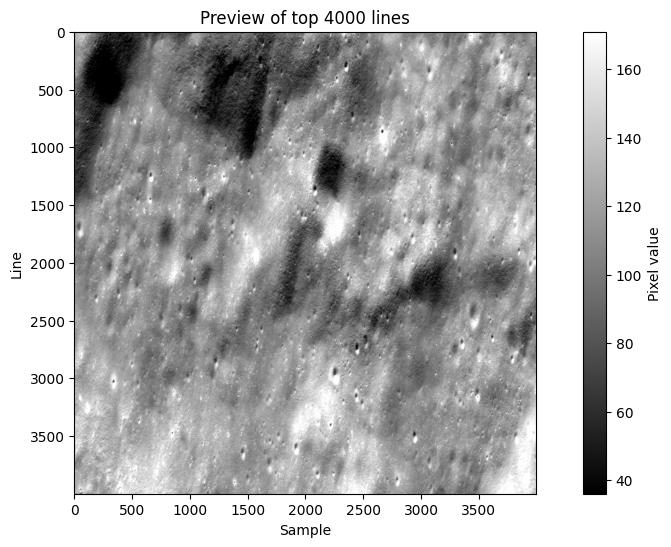

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_file = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img'

# Metadata from XML
img_shape = (205808, 4000)
print("📏 Original full image shape (would be):", img_shape)

# Process only top N lines to avoid crash
N = 4000
with open(img_file, 'rb') as f:
    img = np.fromfile(f, dtype='<u2', count=N * img_shape[1]).reshape((N, img_shape[1]))

print("✅ Loaded partial image shape:", img.shape)

# === Quick visualization ===
plt.figure(figsize=(12,6))
plt.imshow(img, cmap='gray', vmin=np.percentile(img, 1), vmax=np.percentile(img, 99))
plt.title(f"Preview of top {N} lines")
plt.colorbar(label='Pixel value')
plt.xlabel('Sample')
plt.ylabel('Line')
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127769 (\N{CRESCENT MOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


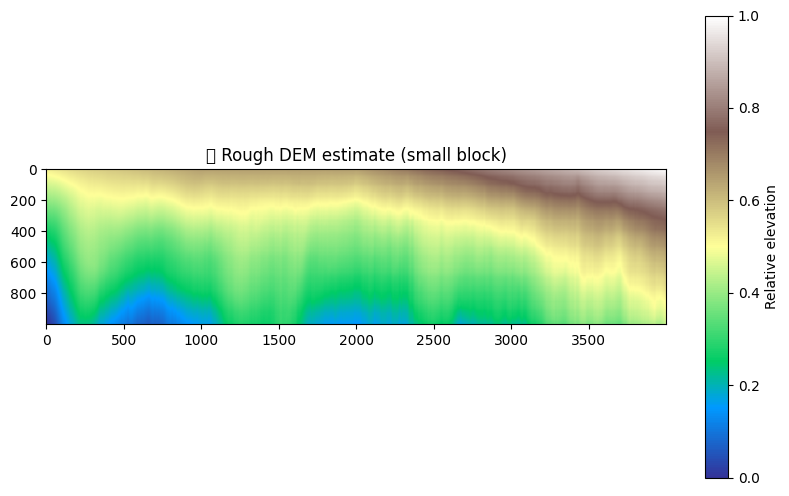

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# === Use small part first (preview) ===
small_img = img[:1000, :]  # safer to try on smaller block

# Normalize
norm = (small_img - small_img.min()) / (small_img.max() - small_img.min())

# === Estimate gradients ===
# Rough: brightness slope → surface slope
# brightness higher = facing sun, lower = away

# Compute gradient magnitude & direction
gy, gx = np.gradient(norm)

# Scale by pixel resolution & sun angle (very rough)
# Convert sun azimuth to radians, measured clockwise from North
sun_az_rad = np.deg2rad(163.9)
sun_el_rad = np.deg2rad(10.6)

# Project gradient onto sun direction (very simplified)
illumination = np.cos(sun_el_rad) * (gx*np.cos(sun_az_rad) + gy*np.sin(sun_az_rad))

# === Integrate gradients to get DEM ===
# cumulative sum over Y and X
dem = np.cumsum(illumination, axis=0)
dem = np.cumsum(dem, axis=1)

# Normalize DEM
dem = (dem - np.min(dem)) / (np.max(dem) - np.min(dem))

plt.figure(figsize=(10,6))
plt.imshow(dem, cmap='terrain')
plt.title("🌙 Rough DEM estimate (small block)")
plt.colorbar(label='Relative elevation')
plt.show()


✅ Loaded partial image: (2000, 4000)
✅ Preprocessing done, shape: (2000, 4000)


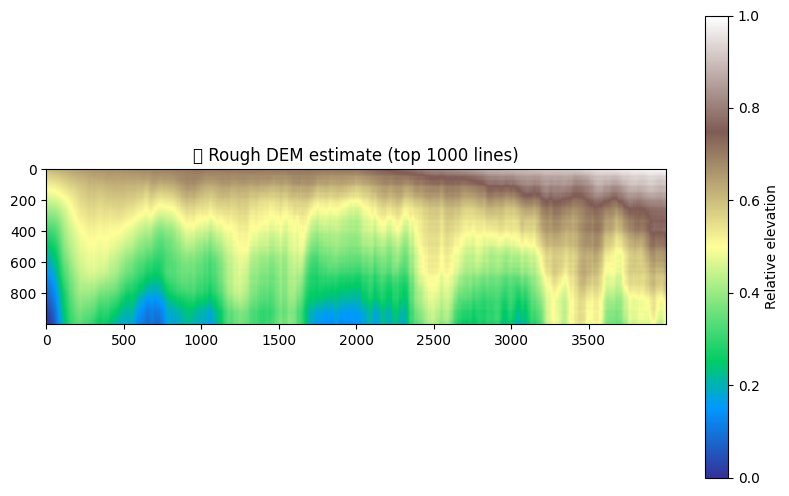

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === Metadata ===
img_shape = (205808, 4000)
sun_elevation = 10.6
sun_azimuth = 163.9
pixel_resolution = 10.57  # m/pixel

# === Step 1: Load partial image (top N lines) ===
N = 2000
img_file = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img'
with open(img_file, 'rb') as f:
    img = np.fromfile(f, dtype='<u2', count=N * img_shape[1]).reshape((N, img_shape[1]))

print("✅ Loaded partial image:", img.shape)

# === Step 2: Noise reduction ===
img_min, img_max = np.percentile(img, [2, 98])
img8 = ((np.clip(img, img_min, img_max) - img_min) / (img_max - img_min) * 255).astype(np.uint8)
denoised8 = cv2.fastNlMeansDenoising(img8, None, h=10, templateWindowSize=7, searchWindowSize=21)
denoised = denoised8.astype(np.float32) / 255.0 * (img_max - img_min) + img_min

# === Step 3: Illumination correction ===
incidence_angle = 90 - sun_elevation
cos_i = np.cos(np.deg2rad(incidence_angle))
illum_corrected = denoised / cos_i
illum_corrected = np.clip(illum_corrected, 0, np.percentile(illum_corrected, 99))

# === Step 4: Contrast enhancement ===
ic_min, ic_max = np.percentile(illum_corrected, [2, 98])
illum8 = ((np.clip(illum_corrected, ic_min, ic_max) - ic_min) / (ic_max - ic_min) * 255).astype(np.uint8)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced8 = clahe.apply(illum8)
enhanced = enhanced8.astype(np.float32) / 255.0

print("✅ Preprocessing done, shape:", enhanced.shape)

# === Step 5: DEM estimation on small block ===
small_img = enhanced[:1000, :]  # take top 1000 lines for DEM
norm = (small_img - small_img.min()) / (small_img.max() - small_img.min())

gy, gx = np.gradient(norm)

# Sun angle in radians
sun_az_rad = np.deg2rad(sun_azimuth)
sun_el_rad = np.deg2rad(sun_elevation)

# Project gradient onto sun direction (simple photoclinometry)
illumination = np.cos(sun_el_rad) * (gx*np.cos(sun_az_rad) + gy*np.sin(sun_az_rad))

# Integrate to get DEM
dem = np.cumsum(illumination, axis=0)
dem = np.cumsum(dem, axis=1)

# Normalize DEM
dem = (dem - np.min(dem)) / (np.max(dem) - np.min(dem))

# === Step 6: Visualize ===
plt.figure(figsize=(10,6))
plt.imshow(dem, cmap='terrain')
plt.title("🌙 Rough DEM estimate (top 1000 lines)")
plt.colorbar(label='Relative elevation')
plt.show()


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft2, ifft2, fftfreq

# -------------------- CLASSICAL SFS --------------------
def lambertian_shade(normals, light_dir, albedo=1.0):
    return albedo * np.clip(np.sum(normals * light_dir.reshape(1, 1, 3), axis=2), 0, 1)

def classical_sfs(I, light_dir, albedo=1.0, iters=300, lr=0.1, smooth_sigma=1.0):
    H, W = I.shape
    Z = np.zeros((H, W), dtype=np.float32)
    for _ in range(iters):
        p = np.gradient(Z, axis=1)
        q = np.gradient(Z, axis=0)

        Nx = -p
        Ny = -q
        Nz = np.ones_like(Z)

        norm = np.sqrt(Nx**2 + Ny**2 + Nz**2 + 1e-8)
        Nx /= norm
        Ny /= norm
        Nz /= norm

        normals = np.dstack((Nx, Ny, Nz))
        I_pred = lambertian_shade(normals, light_dir, albedo)
        diff = I - I_pred

        diff_smoothed = gaussian_filter(diff, sigma=smooth_sigma)
        Z += lr * diff_smoothed

        Z = gaussian_filter(Z, sigma=smooth_sigma)

    return Z

# -------------------- NORMAL INTEGRATION --------------------
def frankot_chellappa(p, q):
    H, W = p.shape
    wx = fftfreq(W).reshape(1, -1)
    wy = fftfreq(H).reshape(-1, 1)
    WX, WY = np.meshgrid(wx, wy)
    denom = WX**2 + WY**2
    denom[denom == 0] = 1e-8

    p_fft = fft2(p)
    q_fft = fft2(q)

    Z_fft = (-1j * WX * p_fft - 1j * WY * q_fft) / denom
    Z = np.real(ifft2(Z_fft))
    return Z

# -------------------- MAIN --------------------
if __name__ == "__main__":
    img_shape = (205808, 4000)
    N = 4000  # Top N lines
    img_file = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img'

    # === Step 1: Load partial image ===
    with open(img_file, 'rb') as f:
        img = np.fromfile(f, dtype='<u2', count=N * img_shape[1]).reshape((N, img_shape[1]))
    print("✅ Loaded partial image:", img.shape)

    # === Step 2: Earlier preprocessing ===
    # a) Noise reduction
    img_min, img_max = np.percentile(img, [2, 98])
    img8 = ((np.clip(img, img_min, img_max) - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    denoised8 = cv2.fastNlMeansDenoising(img8, None, h=10, templateWindowSize=7, searchWindowSize=21)
    denoised = denoised8.astype(np.float32) / 255.0 * (img_max - img_min) + img_min

    # b) Illumination correction
    incidence_angle = 90 - 10.6  # from metadata
    cos_i = np.cos(np.deg2rad(incidence_angle))
    illum_corrected = denoised / cos_i
    illum_corrected = np.clip(illum_corrected, 0, np.percentile(illum_corrected, 99))

    # c) Contrast enhancement (CLAHE)
    ic_min, ic_max = np.percentile(illum_corrected, [2, 98])
    illum8 = ((np.clip(illum_corrected, ic_min, ic_max) - ic_min) / (ic_max - ic_min) * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced8 = clahe.apply(illum8)
    enhanced = enhanced8.astype(np.float32) / 255.0
    print("✅ Preprocessing done")

    # === Step 3: DEM generation with SfS ===
    # Convert sun angles to light vector
    sun_azimuth, sun_elevation = 163.9, 10.6
    az_rad = np.deg2rad(sun_azimuth)
    el_rad = np.deg2rad(sun_elevation)
    light_vector = np.array([
        np.cos(el_rad) * np.cos(az_rad),
        np.cos(el_rad) * np.sin(az_rad),
        np.sin(el_rad)
    ])

    # Use smaller block for DEM first
    small_block = enhanced[:4000, :]

    classical_dem = classical_sfs(small_block, light_vector)

    # Compute gradients and refine
    p = np.gradient(classical_dem, axis=1)
    q = np.gradient(classical_dem, axis=0)
    refined_dem = frankot_chellappa(p, q)

    # Normalize & save
    refined_dem -= np.min(refined_dem)
    refined_dem /= (np.max(refined_dem) + 1e-8)
    dem_img = (refined_dem * 255).astype(np.uint8)
    cv2.imwrite('/content/output_dem.png', dem_img)

    print("✅ DEM saved: /content/output_dem.png")

    # Optional view
    plt.figure(figsize=(10,6))
    plt.imshow(refined_dem, cmap='terrain')
    plt.title('🌙 DEM from SfS after preprocessing')
    plt.colorbar()
    plt.show()


✅ Loaded partial image: (4000, 4000)
✅ Preprocessing done
✅ DEM saved: /content/output_dem.png


✅ Sun vector: [ 0.2725506  -0.94439261  0.18395319]
✅ Loaded raw top 2000 lines: (2000, 4000)
✅ Preprocessing done
✅ DEM saved: output_dem_bw.png


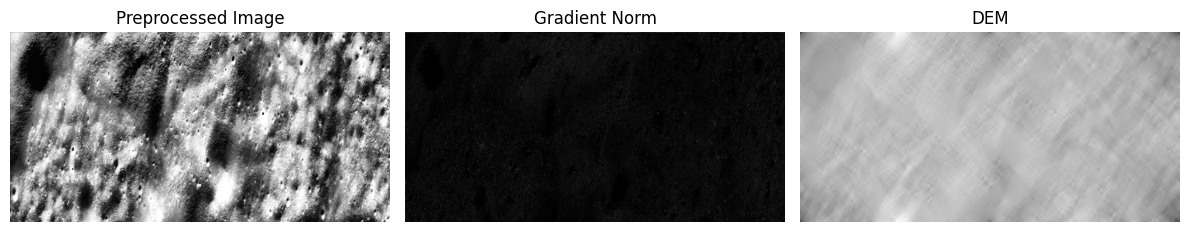

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy.fftpack import fft2, ifft2
from scipy.ndimage import gaussian_filter

# -------------------- XML METADATA --------------------
def parse_metadata(xml_path):
    ns = {'isda': 'https://isda.issdc.gov.in/pds4/isda/v1'}
    tree = ET.parse(xml_path)
    root = tree.getroot()
    def get(tag): return float(root.find(f'.//isda:{tag}', ns).text)
    return {'sun_azimuth': get('sun_azimuth'), 'sun_elevation': get('sun_elevation')}

def compute_sun_vector(azimuth_deg, elevation_deg):
    az = np.radians(azimuth_deg)
    el = np.radians(elevation_deg)
    L = np.array([np.cos(el)*np.sin(az), np.cos(el)*np.cos(az), np.sin(el)])
    return L / np.linalg.norm(L)

# -------------------- YOUR RAW IMG PREPROCESSING --------------------
def preprocess_raw_img(img_file, N=2000, img_width=4000):
    with open(img_file, 'rb') as f:
        img = np.fromfile(f, dtype='<u2', count=N*img_width).reshape((N, img_width))
    print("✅ Loaded raw top", N, "lines:", img.shape)

    # Normalize to 0–1 float
    img_min, img_max = np.percentile(img, [2, 98])
    norm = np.clip(img, img_min, img_max)
    norm = (norm - img_min) / (img_max - img_min)

    # Denoise
    sigma_est = np.mean(estimate_sigma(norm, channel_axis=None))
    denoised = denoise_nl_means(norm, h=1.15*sigma_est, patch_size=5, patch_distance=6, channel_axis=None)

    # CLAHE
    img_uint8 = np.round(denoised * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_uint8)

    preprocessed = clahe_img.astype(np.float32) / 255.0
    print("✅ Preprocessing done")
    return preprocessed

# -------------------- DEM CORE --------------------
def estimate_slope(I, light_vec):
    epsilon=1e-6
    Lz = light_vec[2]+epsilon
    gx, gy = np.gradient(I)
    p = -gx / Lz
    q = -gy / Lz
    return p, q

def poisson_integration(p, q):
    H,W = p.shape
    fx = np.gradient(p, axis=1)
    fy = np.gradient(q, axis=0)
    div = fx + fy

    yy, xx = np.meshgrid(np.fft.fftfreq(H), np.fft.fftfreq(W), indexing='ij')
    denom = (2*np.pi*xx)**2 + (2*np.pi*yy)**2
    denom[0,0]=1e-8

    Z = np.real(ifft2(fft2(div)/denom))
    Z -= np.min(Z)
    Z /= (np.max(Z)+1e-8)
    return Z

# -------------------- PIPELINE --------------------
def generate_dem_pipeline(raw_img_file, xml_file):
    # Parse sun
    meta = parse_metadata(xml_file)
    L = compute_sun_vector(meta['sun_azimuth'], meta['sun_elevation'])
    print("✅ Sun vector:", L)

    # Preprocess
    img = preprocess_raw_img(raw_img_file)

    # Slope
    p,q = estimate_slope(img, L)

    # DEM
    Z = poisson_integration(p,q)
    Z = gaussian_filter(Z, sigma=1.0)

    # Save
    dem_img = (Z*255).astype(np.uint8)
    cv2.imwrite("output_dem_bw.png", dem_img)
    print("✅ DEM saved: output_dem_bw.png")

    # Visualize in black and white
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title("Preprocessed Image"); plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(np.sqrt(p**2+q**2), cmap='gray')
    plt.title("Gradient Norm"); plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(Z, cmap='gray')
    plt.title("DEM"); plt.axis('off')

    plt.tight_layout(); plt.show()

# -------------------- RUN --------------------
if __name__=="__main__":
    raw_img_file = "/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img"
    xml_file = "/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.xml"
    generate_dem_pipeline(raw_img_file, xml_file)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy.fftpack import fft2, ifft2
from scipy.ndimage import gaussian_filter

# -------------------- STEP 1: XML METADATA PARSER --------------------
def parse_metadata(xml_path):
    ns = {'isda': 'https://isda.issdc.gov.in/pds4/isda/v1'}
    tree = ET.parse(xml_path)
    root = tree.getroot()

    def get(tag):
        return float(root.find(f'.//isda:{tag}', ns).text)

    return {
        'sun_azimuth': get('sun_azimuth'),
        'sun_elevation': get('sun_elevation'),
        'roll': get('roll'),
        'pitch': get('pitch'),
        'yaw': get('yaw'),
    }

# -------------------- STEP 2: COMPUTE SUN VECTOR --------------------
def compute_sun_vector(azimuth_deg, elevation_deg):
    az = np.radians(azimuth_deg)
    el = np.radians(elevation_deg)
    Lx = np.cos(el) * np.sin(az)
    Ly = np.cos(el) * np.cos(az)
    Lz = np.sin(el)
    L = np.array([Lx, Ly, Lz])
    return L / np.linalg.norm(L)

# -------------------- STEP 3: IMAGE PREPROCESSING --------------------
def preprocess_image(img):
    img = img.astype(np.float32)
    img -= img.min()
    img /= img.max() + 1e-8

    sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
    denoised = denoise_nl_means(img, h=1.15 * sigma_est, patch_size=5, patch_distance=6, channel_axis=None)

    p2, p98 = np.percentile(denoised, (2, 98))
    stretched = np.clip(denoised, p2, p98)
    normalized = (stretched - p2) / (p98 - p2 + 1e-5)

    img_uint8 = np.round(normalized * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(img_uint8)

    preprocessed = clahe_img.astype(np.float32) / 255.0
    return preprocessed

# -------------------- STEP 4: SLOPE ESTIMATION --------------------
def estimate_slope(I, light_vec):
    epsilon = 1e-6
    I = np.clip(I, 0, 1)
    Lx, Ly, Lz = light_vec

    grad_x = np.gradient(I, axis=1)
    grad_y = np.gradient(I, axis=0)

    p = -grad_x / (Lz + epsilon)
    q = -grad_y / (Lz + epsilon)
    return p, q

# -------------------- STEP 5: FUSE MULTI-IMAGE GRADIENTS --------------------
def fuse_gradients(p1, q1, p2=None, q2=None):
    if p2 is None or q2 is None:
        return p1, q1
    return (p1 + p2) / 2, (q1 + q2) / 2

# -------------------- STEP 6: POISSON INTEGRATION --------------------
def poisson_integration(p, q):
    h, w = p.shape
    fx = np.gradient(p, axis=1)
    fy = np.gradient(q, axis=0)
    div = fx + fy

    yy, xx = np.meshgrid(np.fft.fftfreq(h), np.fft.fftfreq(w), indexing='ij')
    denom = (2 * np.pi * xx) ** 2 + (2 * np.pi * yy) ** 2
    denom[0, 0] = 1  # avoid divide-by-zero

    Z = np.real(ifft2(fft2(div) / denom))
    Z -= np.min(Z)
    Z /= np.max(Z) + 1e-8
    return Z

# -------------------- STEP 7: FULL PIPELINE --------------------
def photoclinometry_dem_from_raw(raw_img, xml_path, output_path="output_dem.png"):
    # Parse sun vector
    meta = parse_metadata(xml_path)
    L = compute_sun_vector(meta['sun_azimuth'], meta['sun_elevation'])

    # Preprocess raw image
    img_preprocessed = preprocess_image(raw_img)

    # Estimate slopes
    p, q = estimate_slope(img_preprocessed, L)

    # ----- PSEUDO-DISPARITY MAP -----
    pseudo_disparity = np.abs(p)
    pseudo_disparity -= np.min(pseudo_disparity)
    pseudo_disparity /= np.max(pseudo_disparity) + 1e-8
    disparity_img = (pseudo_disparity * 255).astype(np.uint8)
    cv2.imwrite("pseudo_disparity.png", disparity_img)
    print("🟦 Pseudo-disparity map saved as 'pseudo_disparity.png'")

    # ----- DEM -----
    Z = poisson_integration(p, q)
    Z = gaussian_filter(Z, sigma=1.0)
    dem_img = ((Z - np.min(Z)) / (np.max(Z) - np.min(Z)) * 255).astype(np.uint8)
    cv2.imwrite(output_path, dem_img)
    print(f"✅ DEM saved to: {output_path}")

    # Show plots
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(img_preprocessed, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(np.sqrt(p**2 + q**2), cmap='inferno')
    plt.title("Gradient Norms")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pseudo_disparity, cmap='gray')
    plt.title("Pseudo-Disparity Map")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(Z, cmap='gray')
    plt.title("Estimated Height Map")
    plt.colorbar()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------- USAGE --------------------
if __name__ == "__main__":
    # === STEP A: Read raw `.img` ===
    img_file = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img'
    img_shape = (205808, 4000)

    N = 2000  # process only top N lines
    with open(img_file, 'rb') as f:
        raw_img = np.fromfile(f, dtype='<u2', count=N * img_shape[1]).reshape((N, img_shape[1]))

    # === STEP B: XML metadata path ===
    xml_file = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.xml'

    # === STEP C: Run pipeline ===
    photoclinometry_dem_from_raw(raw_img, xml_file)


🟦 Pseudo-disparity map saved as 'pseudo_disparity.png'
✅ DEM saved to: output_dem.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paths (replace these with your real paths)
image_path_1 = "/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img"
xml_path_1 = "/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.xml"

# Step: parse metadata
meta1 = parse_metadata(xml_path_1)

# Step: compute sun vector
light_vec = compute_sun_vector(meta1['sun_azimuth'], meta1['sun_elevation'])

print("Light vector:", light_vec)

# Step: load and preprocess image
img1 = preprocess_image(image_path_1)

# Step: estimate slopes
p, q = estimate_slope(img1, light_vec)

# Debug prints
print("p range:", np.min(p), np.max(p))
print("q range:", np.min(q), np.max(q))

grad_norm = np.sqrt(p**2 + q**2)
print("Gradient norm range:", np.min(grad_norm), np.max(grad_norm))

# Plot
plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(p, cmap='gray'); plt.title('p'); plt.colorbar()
plt.subplot(1,3,2); plt.imshow(q, cmap='gray'); plt.title('q'); plt.colorbar()
plt.subplot(1,3,3); plt.imshow(grad_norm, cmap='gray'); plt.title('Gradient norm'); plt.colorbar()
plt.show()


Light vector: [ 0.2725506  -0.94439261  0.18395319]


AttributeError: 'str' object has no attribute 'astype'

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy.fftpack import fft2, ifft2
from scipy.ndimage import gaussian_filter

# -------------------- STEP 1: XML METADATA PARSER --------------------
def parse_metadata(xml_path):
    ns = {'isda': 'https://isda.issdc.gov.in/pds4/isda/v1'}
    tree = ET.parse(xml_path)
    root = tree.getroot()

    def get(tag):
        return float(root.find(f'.//isda:{tag}', ns).text)

    sun_azimuth = get('sun_azimuth')
    sun_elevation = get('sun_elevation')
    print(f"Sun azimuth: {sun_azimuth}, elevation: {sun_elevation}")
    return sun_azimuth, sun_elevation

# -------------------- STEP 2: COMPUTE SUN VECTOR --------------------
def compute_sun_vector(azimuth_deg, elevation_deg):
    az = np.radians(azimuth_deg)
    el = np.radians(elevation_deg)
    Lx = np.cos(el) * np.sin(az)
    Ly = np.cos(el) * np.cos(az)
    Lz = np.sin(el)
    L = np.array([Lx, Ly, Lz])
    L /= np.linalg.norm(L)
    print("Light vector:", L)
    return L

# -------------------- STEP 3: IMAGE PREPROCESSING --------------------
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = img.astype(np.float32) / 255.0
    print("Loaded img min/max:", img.min(), img.max())

    # optional: smooth a bit to avoid noisy gradients
    img = gaussian_filter(img, sigma=1)

    # Denoise
    sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
    denoised = denoise_nl_means(img, h=1.15 * sigma_est, patch_size=5, patch_distance=6, channel_axis=None)

    # Contrast stretching with percentile clipping
    p2, p98 = np.percentile(denoised, (2, 98))
    stretched = np.clip(denoised, p2, p98)
    normalized = (stretched - p2) / (p98 - p2 + 1e-8)
    print("Preprocessed img min/max:", normalized.min(), normalized.max())

    return normalized

# -------------------- STEP 4: SLOPE ESTIMATION --------------------
def estimate_slope(I, light_vec):
    epsilon = 1e-6
    Lz = light_vec[2]
    grad_x = np.gradient(I, axis=1)
    grad_y = np.gradient(I, axis=0)
    p = -grad_x / (Lz + epsilon)
    q = -grad_y / (Lz + epsilon)
    print("p min/max:", p.min(), p.max())
    print("q min/max:", q.min(), q.max())
    return p, q

# -------------------- STEP 5: POISSON INTEGRATION --------------------
def poisson_integration(p, q):
    h, w = p.shape
    fx = np.gradient(p, axis=1)
    fy = np.gradient(q, axis=0)
    div = fx + fy

    yy, xx = np.meshgrid(np.fft.fftfreq(h), np.fft.fftfreq(w), indexing='ij')
    denom = (2 * np.pi * xx)**2 + (2 * np.pi * yy)**2
    denom[0, 0] = 1  # Avoid division by zero

    Z = np.real(ifft2(fft2(div) / denom))
    print("DEM raw min/max:", Z.min(), Z.max())
    Z -= Z.min()
    Z /= Z.max() + 1e-8
    return Z

# -------------------- STEP 6: MAIN PIPELINE --------------------
def photoclinometry_pipeline(image_path_1, xml_path_1, output_path="output_dem.png"):
    # Parse metadata & compute light vector
    sun_azimuth, sun_elevation = parse_metadata(xml_path_1)
    light_vec = compute_sun_vector(sun_azimuth, sun_elevation)

    # Preprocess image
    img1 = preprocess_image(image_path_1)

    # Estimate slopes
    p, q = estimate_slope(img1, light_vec)

    # Gradient norms visualization (with clipping to handle outliers)
    grad_norm = np.sqrt(p**2 + q**2)
    max_grad = np.percentile(grad_norm, 99)
    grad_norm = np.clip(grad_norm, 0, max_grad)
    grad_norm /= max_grad
    print("Gradient norm min/max:", grad_norm.min(), grad_norm.max())

    # Pseudo disparity map (also with percentile clipping)
    pseudo_disparity = np.abs(p)
    maxval = np.percentile(pseudo_disparity, 99)
    pseudo_disparity = np.clip(pseudo_disparity, 0, maxval)
    pseudo_disparity /= maxval
    print("Pseudo disparity min/max:", pseudo_disparity.min(), pseudo_disparity.max())

    cv2.imwrite("pseudo_disparity.png", (pseudo_disparity * 255).astype(np.uint8))

    # DEM
    Z = poisson_integration(p, q)
    Z = gaussian_filter(Z, sigma=1.0)
    dem_img = (Z * 255).astype(np.uint8)
    cv2.imwrite(output_path, dem_img)
    print(f"✅ DEM saved to: {output_path}")

    # Show results
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(img1, cmap='gray')
    plt.title("Preprocessed Image"); plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(grad_norm, cmap='gray')
    plt.title("Gradient Norms"); plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pseudo_disparity, cmap='gray')
    plt.title("Pseudo-Disparity"); plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(Z, cmap='gray')
    plt.title("Estimated Height Map"); plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------- USAGE --------------------
# ✅ replace with your actual file paths
image_path = "/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img"
xml_path_1 = "/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.xml"

photoclinometry_pipeline(image_path_1, xml_path_1)


Sun azimuth: 163.901922, elevation: 10.600107
Light vector: [ 0.2725506  -0.94439261  0.18395319]


FileNotFoundError: Image not found: /content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img

{http://pds.nasa.gov/pds4/pds/v1}Product_Observational : 

    
{http://pds.nasa.gov/pds4/pds/v1}Identification_Area : 
        
{http://pds.nasa.gov/pds4/pds/v1}logical_identifier : urn:isro:isda:ch1_cho.tmc:data_calibrated:ch1_tmc_ncn_20090529t2139554127_d_img_apl
{http://pds.nasa.gov/pds4/pds/v1}version_id : 1.0
{http://pds.nasa.gov/pds4/pds/v1}title : Chandrayaan-1 Orbiter TMC Experiment
{http://pds.nasa.gov/pds4/pds/v1}information_model_version : 1.11.0.0
{http://pds.nasa.gov/pds4/pds/v1}product_class : Product_Observational
{http://pds.nasa.gov/pds4/pds/v1}Modification_History : 
            
{http://pds.nasa.gov/pds4/pds/v1}Modification_Detail : 
                
{http://pds.nasa.gov/pds4/pds/v1}modification_date : 2024-01-30
{http://pds.nasa.gov/pds4/pds/v1}version_id : 1.0
{http://pds.nasa.gov/pds4/pds/v1}description : PDS4 product label created by SAC DP Team
{http://pds.nasa.gov/pds4/pds/v1}Observation_Area : 
        
{http://pds.nasa.gov/pds4/pds/v1}Time_Coordinates : 
   

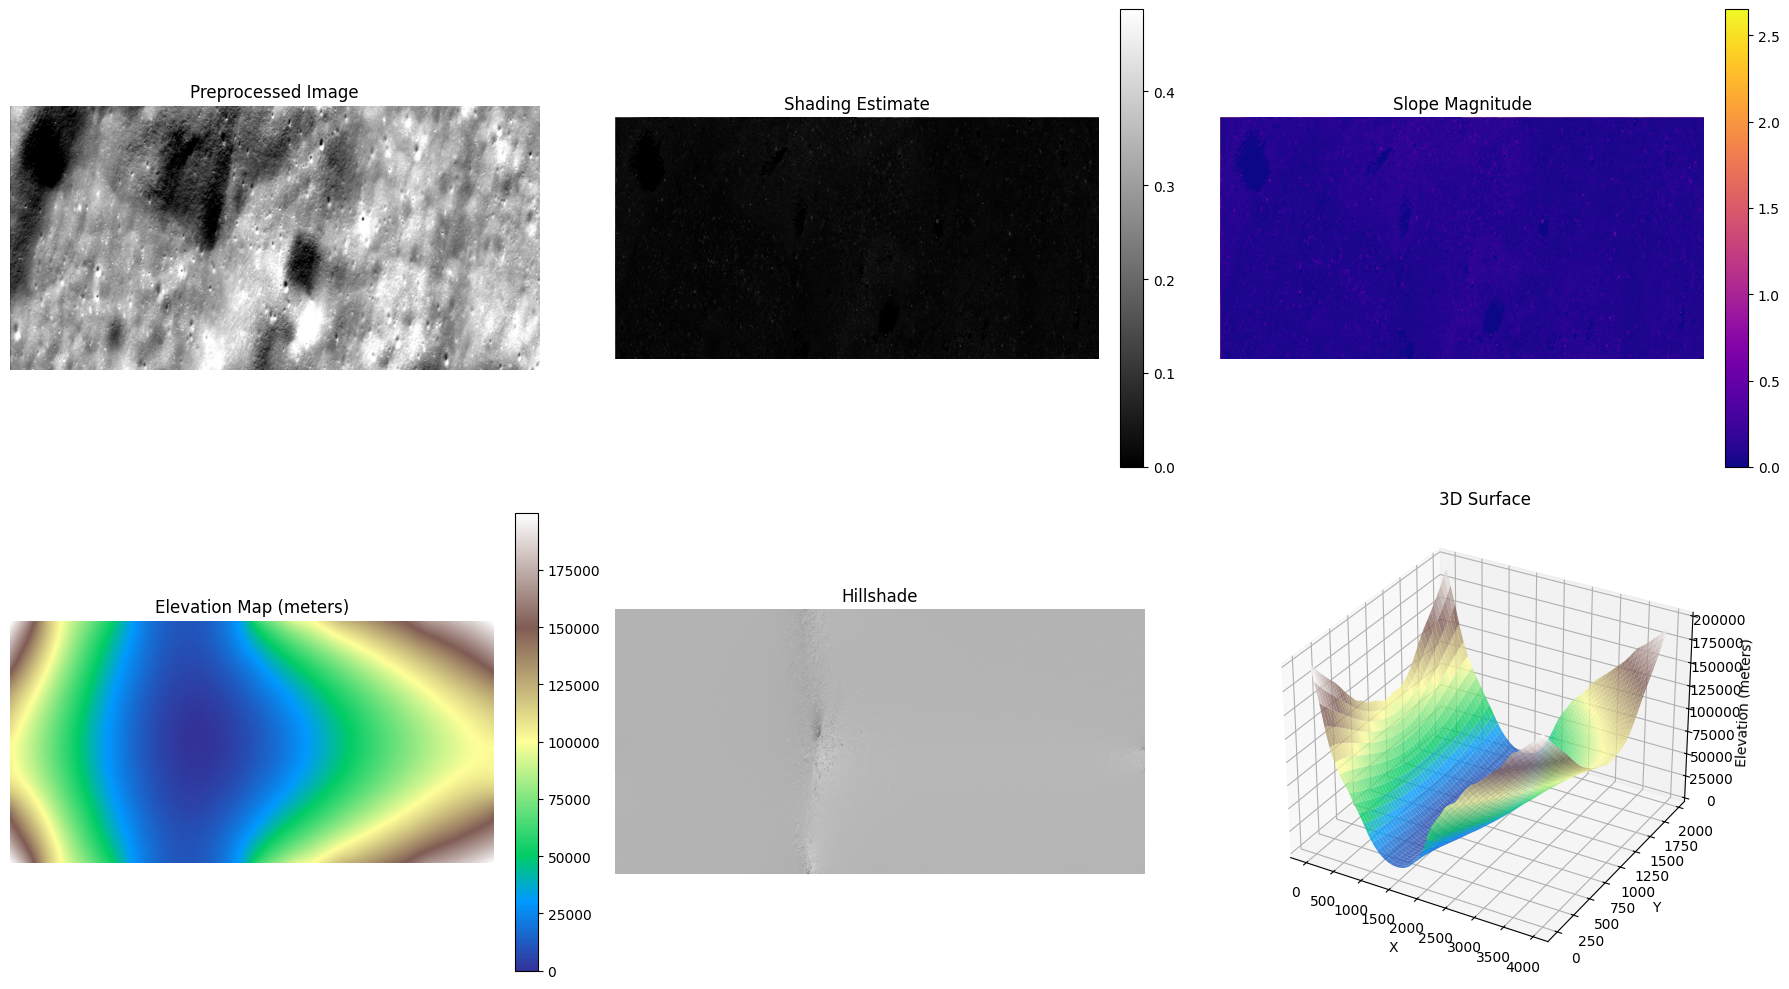

✅ Done! Height range: 0.00 to 200000.00 meters


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from scipy.fftpack import fft2, ifft2
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import logging
from typing import Dict, Tuple, Optional, Union

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class PhotoclinometryProcessor:
    def __init__(self, config: Optional[Dict] = None):
        self.config = self._get_default_config()
        if config:
            self.config.update(config)

    def _get_default_config(self) -> Dict:
        return {
            'clahe_clip_limit': 3.0,
            'clahe_tile_size': (8, 8),
            'bilateral_d': 9,
            'bilateral_sigma_color': 0.1,
            'bilateral_sigma_space': 15,
            'gamma_correction': 1.2,
            'gaussian_sigma': 1.0,
            'epsilon': 1e-6,
            'output_dpi': 300,
            'figure_size': (18, 10)
        }

    def parse_metadata(self, xml_path: Union[str, Path]) -> Dict[str, float]:
        xml_path = Path(xml_path)
        if not xml_path.exists():
            raise FileNotFoundError(f"XML file not found: {xml_path}")

        ns = {'isda': 'https://isda.issdc.gov.in/pds4/isda/v1'}
        tree = ET.parse(xml_path)
        root = tree.getroot()

        def safe_get(tag: str) -> float:
            elem = root.find(f'.//isda:{tag}', ns)
            if elem is not None and elem.text:
                try:
                    return float(elem.text)
                except ValueError:
                    logger.warning(f"Could not convert {tag} to float: {elem.text}")
                    return 0.0
            raise ValueError(f"Tag {tag} not found in XML: {xml_path}")

        metadata = {
            'sun_azimuth': safe_get('sun_azimuth'),
            'sun_elevation': safe_get('sun_elevation'),
            'roll': safe_get('roll'),
            'pitch': safe_get('pitch'),
            'yaw': safe_get('yaw'),
        }

        logger.info(f"Parsed metadata: {metadata}")
        return metadata

    def compute_sun_vector(self, azimuth_deg: float, elevation_deg: float) -> np.ndarray:
        az = np.radians(azimuth_deg)
        el = np.radians(elevation_deg)
        Lx = np.cos(el) * np.sin(az)
        Ly = np.cos(el) * np.cos(az)
        Lz = np.sin(el)
        return np.array([Lx, Ly, Lz]) / np.linalg.norm([Lx, Ly, Lz])

    def preprocess_image(self, image_path: Union[str, Path]) -> np.ndarray:
        image_path = Path(image_path)
        if not image_path.exists():
            raise FileNotFoundError(f"Image not found: {image_path}")

        ext = image_path.suffix.lower()
        if ext == '.img':
            # Load raw binary: typical TMC shape
            img = np.fromfile(str(image_path), dtype=np.uint16)
            expected_shape = (205808, 4000)
            if img.size != np.prod(expected_shape):
                raise ValueError(f"Unexpected file size: got {img.size}, expected {np.prod(expected_shape)}")
            img = img.reshape(expected_shape)
            logger.info(f"Loaded raw .img file: shape={img.shape}, dtype={img.dtype}")
            img = img[:2000, :]  # optional crop for speed
            img = img.astype(np.float32)
            img -= img.min()
            img /= img.max() + self.config['epsilon']
            img = gaussian_filter(img, sigma=1)
            p2, p98 = np.percentile(img, (2, 98))
            img = np.clip(img, p2, p98)
            img = (img - p2) / (p98 - p2 + self.config['epsilon'])
        else:
            img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Could not load image: {image_path}")
            logger.info(f"Loaded image: shape={img.shape}, dtype={img.dtype}")
            img = img.astype(np.float32) / 255.0
            clahe = cv2.createCLAHE(
                clipLimit=self.config['clahe_clip_limit'],
                tileGridSize=self.config['clahe_tile_size']
            )
            img = clahe.apply((img * 255).astype(np.uint8)).astype(np.float32) / 255.0
            img = cv2.bilateralFilter(
                img,
                d=self.config['bilateral_d'],
                sigmaColor=self.config['bilateral_sigma_color'],
                sigmaSpace=self.config['bilateral_sigma_space']
            )
            img = np.power(img, self.config['gamma_correction'])
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + self.config['epsilon'])

        logger.info(f"Preprocessing complete. Range: [{img.min():.3f}, {img.max():.3f}]")
        return img

    def estimate_slope(self, image: np.ndarray, light_vec: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        grad_x = np.gradient(image, axis=1)
        grad_y = np.gradient(image, axis=0)
        Lz = light_vec[2] if abs(light_vec[2]) > self.config['epsilon'] else self.config['epsilon']
        p = -grad_x / Lz
        q = -grad_y / Lz
        slope_limit = 5.0
        return np.clip(p, -slope_limit, slope_limit), np.clip(q, -slope_limit, slope_limit)

    def poisson_integration(self, p: np.ndarray, q: np.ndarray) -> np.ndarray:
        h, w = p.shape
        div = np.gradient(p, axis=1) + np.gradient(q, axis=0)
        yy, xx = np.meshgrid(np.fft.fftfreq(h), np.fft.fftfreq(w), indexing='ij')
        denom = (2 * np.pi * xx)**2 + (2 * np.pi * yy)**2
        denom[0, 0] = 1
        Z = np.real(ifft2(fft2(div) / denom))
        return Z - np.mean(Z)

    def apply_smoothing(self, height_map: np.ndarray) -> np.ndarray:
        return gaussian_filter(height_map, sigma=self.config['gaussian_sigma'])

    def scale_height_map(self, height_map: np.ndarray, meters_per_pixel: Optional[float] = None) -> Tuple[np.ndarray, str]:
        height_norm = (height_map - np.min(height_map)) / (np.max(height_map) - np.min(height_map) + self.config['epsilon'])
        if meters_per_pixel:
            max_height_pixels = np.max(height_norm) * max(height_map.shape)
            height_abs = height_norm * meters_per_pixel * max_height_pixels
            return height_abs, "meters"
        else:
            return height_norm, "relative units"

    def create_visualization(self, image, height_map, slope_magnitude, unit, output_path=None):
        fig = plt.figure(figsize=self.config['figure_size'])
        ax1 = fig.add_subplot(2, 3, 1)
        ax1.imshow(image, cmap='gray')
        ax1.set_title("Preprocessed Image")
        ax1.axis('off')
        ax2 = fig.add_subplot(2, 3, 2)
        shading = np.sqrt(np.gradient(image, axis=0)**2 + np.gradient(image, axis=1)**2)
        shading_plot = ax2.imshow(shading, cmap='gray')
        ax2.set_title("Shading Estimate")
        ax2.axis('off')
        plt.colorbar(shading_plot, ax=ax2, fraction=0.046, pad=0.04)
        ax3 = fig.add_subplot(2, 3, 3)
        slope_plot = ax3.imshow(slope_magnitude, cmap='plasma')
        ax3.set_title("Slope Magnitude")
        ax3.axis('off')
        plt.colorbar(slope_plot, ax=ax3, fraction=0.046, pad=0.04)
        ax4 = fig.add_subplot(2, 3, 4)
        elev_plot = ax4.imshow(height_map, cmap='terrain')
        ax4.set_title(f"Elevation Map ({unit})")
        ax4.axis('off')
        plt.colorbar(elev_plot, ax=ax4, fraction=0.046, pad=0.04)
        ax5 = fig.add_subplot(2, 3, 5)
        hillshade = self._create_hillshade(height_map)
        ax5.imshow(hillshade, cmap='gray')
        ax5.set_title("Hillshade")
        ax5.axis('off')
        ax6 = fig.add_subplot(2, 3, 6, projection='3d')
        X, Y = np.meshgrid(np.arange(height_map.shape[1]), np.arange(height_map.shape[0]))
        stride = max(1, max(height_map.shape) // 100)
        X_sub = X[::stride, ::stride]
        Y_sub = Y[::stride, ::stride]
        Z_sub = height_map[::stride, ::stride]
        ax6.plot_surface(X_sub, Y_sub, Z_sub, cmap='terrain', alpha=0.8, linewidth=0)
        ax6.set_title("3D Surface")
        ax6.set_xlabel("X")
        ax6.set_ylabel("Y")
        ax6.set_zlabel(f"Elevation ({unit})")
        plt.tight_layout()
        if output_path:
            plt.savefig(output_path, dpi=self.config['output_dpi'])
            logger.info(f"Visualization saved: {output_path}")
        plt.show()

    def _create_hillshade(self, height_map, azimuth=315, elevation=45):
        grad_x = np.gradient(height_map, axis=1)
        grad_y = np.gradient(height_map, axis=0)
        azimuth_rad = np.radians(azimuth)
        elevation_rad = np.radians(elevation)
        slope = np.arctan(np.sqrt(grad_x**2 + grad_y**2))
        aspect = np.arctan2(-grad_x, grad_y)
        return np.clip(np.sin(elevation_rad) * np.sin(slope) +
                       np.cos(elevation_rad) * np.cos(slope) * np.cos(azimuth_rad - aspect), 0, 1)

    def save_dem(self, height_map, output_path):
        dem_norm = (height_map - np.min(height_map)) / (np.max(height_map) - np.min(height_map) + self.config['epsilon'])
        dem_img = (dem_norm * 255).astype(np.uint8)
        cv2.imwrite(str(output_path), dem_img)
        logger.info(f"DEM saved: {output_path}")

    def process(self, image_path, xml_path, meters_per_pixel=None, output_dem_path=None, output_viz_path=None):
        metadata = self.parse_metadata(xml_path)
        sun_vector = self.compute_sun_vector(metadata['sun_azimuth'], metadata['sun_elevation'])
        image = self.preprocess_image(image_path)
        p, q = self.estimate_slope(image, sun_vector)
        slope_magnitude = np.sqrt(p**2 + q**2)
        height_map = self.poisson_integration(p, q)
        height_map = self.apply_smoothing(height_map)
        height_scaled, unit = self.scale_height_map(height_map, meters_per_pixel)
        self.create_visualization(image, height_scaled, slope_magnitude, unit, output_viz_path)
        if output_dem_path:
            self.save_dem(height_scaled, output_dem_path)
        return {'metadata': metadata, 'height_map': height_scaled, 'unit': unit, 'height_range': (np.min(height_scaled), np.max(height_scaled))}

def main():
    config = {'clahe_clip_limit': 2.5, 'gamma_correction': 1.1, 'gaussian_sigma': 1.5}
    processor = PhotoclinometryProcessor(config)
    image_path = "/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img"   # replace with your .img or .tif
    xml_path = "/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.xml"
    try:
        results = processor.process(
            image_path=image_path,
            xml_path=xml_path,
            meters_per_pixel=50,
            output_dem_path="enhanced_dem.png",
            output_viz_path="enhanced_visualization.png"
        )
        print(f"✅ Done! Height range: {results['height_range'][0]:.2f} to {results['height_range'][1]:.2f} {results['unit']}")
    except Exception as e:
        print(f"❌ Error: {e}")

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import exposure
from scipy.fft import fft2, ifft2
from scipy.ndimage import sobel
from mpl_toolkits.mplot3d import Axes3D

# ====== STEP 1: LOAD IMAGE ======
image_path = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img'  # Replace with your path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# ====== STEP 2: IMAGE PREPROCESSING ======
# Denoise using Non-Local Means
sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
patch_kw = dict(patch_size=5, patch_distance=6, channel_axis=None)
img_denoised = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True, **patch_kw)

# CLAHE contrast enhancement
img_eq = exposure.equalize_adapthist(img_denoised, clip_limit=0.03)

# ====== STEP 3: PARSE XML FOR ILLUMINATION DIRECTION ======
def parse_xml_metadata(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    ns = {'ns': root.tag.split('}')[0].strip('{')}

    inc_angle = float(root.find('.//ns:INCIDENCE_ANGLE', ns).text)
    azimuth = float(root.find('.//ns:SOLAR_AZIMUTH_ANGLE', ns).text)

    inc_rad = np.radians(inc_angle)
    azi_rad = np.radians(azimuth)

    s = np.array([
        np.sin(inc_rad) * np.sin(azi_rad),
        np.sin(inc_rad) * np.cos(azi_rad),
        np.cos(inc_rad)
    ])
    return s, inc_angle

xml_path = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.xml'  # Replace with your XML file
light_dir, incidence_angle = parse_xml_metadata(xml_path)

# ====== STEP 4: GRADIENT FIELD ESTIMATION ======
I = img_eq
sx, sy, sz = light_dir

# Approximate small-slope reflectance inversion
p = (I * sz - 1) * (-sx)
q = (I * sz - 1) * (-sy)

# ====== STEP 5: SURFACE RECONSTRUCTION (Poisson Solver) ======
def integrate_surface(p, q):
    fx = fft2(p)
    fy = fft2(q)
    rows, cols = p.shape
    y, x = np.meshgrid(np.fft.fftfreq(cols), np.fft.fftfreq(rows))
    D = (2j * np.pi * x) * fx + (2j * np.pi * y) * fy
    D /= (4 * np.pi ** 2) * (x ** 2 + y ** 2) + 1e-8
    surface = np.real(ifft2(D))
    return surface

Z_rel = integrate_surface(p, q)

# ====== STEP 6: ABSOLUTE DEM CONVERSION ======
scale_factor = np.tan(np.radians(incidence_angle))  # Approximate scaling to meters
Z_abs = Z_rel * scale_factor

# ====== STEP 7: DISPLAY INPUT & DEMS ======
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(img_eq, cmap='gray')
axs[0].set_title("Preprocessed Input Image")

axs[1].imshow(Z_rel, cmap='terrain')
axs[1].set_title("Relative DEM (unitless)")

im = axs[2].imshow(Z_abs, cmap='terrain')
axs[2].set_title("Absolute DEM (approx. meters)")
fig.colorbar(im, ax=axs[2])

plt.tight_layout()
plt.show()

# ====== STEP 8: DISPARITY MAP ======
disp_x = sobel(Z_rel, axis=1)
disp_y = sobel(Z_rel, axis=0)
disparity_map = np.hypot(disp_x, disp_y)

plt.figure(figsize=(6, 5))
plt.imshow(disparity_map, cmap='inferno')
plt.title("Disparity Map (Gradient of DEM)")
plt.colorbar(label="Relative Disparity (unitless)")
plt.tight_layout()
plt.show()

# ====== STEP 9: 3D SURFACE MODEL ======
X, Y = np.meshgrid(np.arange(Z_abs.shape[1]), np.arange(Z_abs.shape[0]))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_abs, cmap='terrain', linewidth=0, antialiased=False)

ax.set_title("3D Terrain Surface Model")
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.set_zlabel("Elevation (meters)")
fig.colorbar(surf, shrink=0.5, aspect=10, label='Elevation (m)')

plt.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'astype'

✅ Loaded raw image: (4000, 4000)
✅ Preprocessing done
✅ Parsed illumination: incidence=10.60°, azimuth=..., light_vec=[ 0.05100699 -0.1767401   0.98293501]


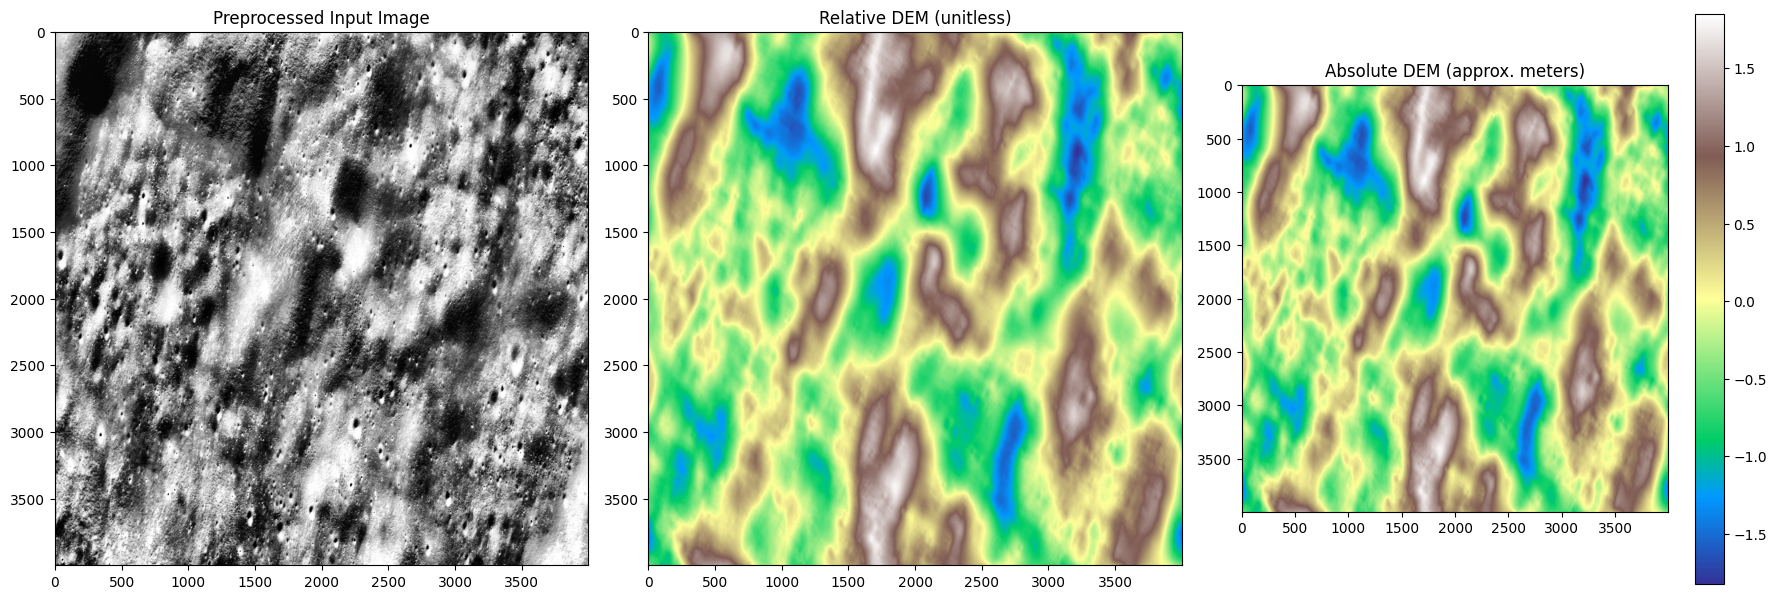

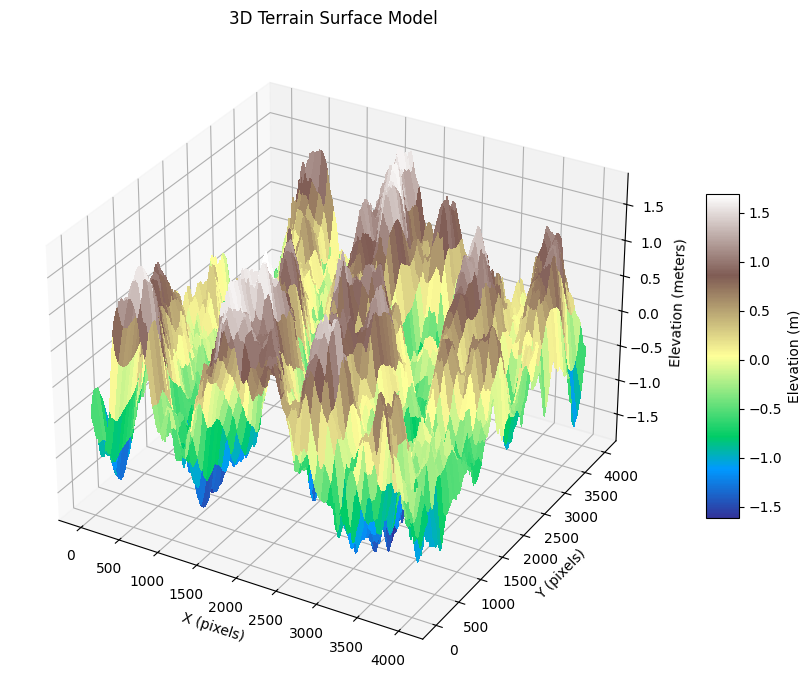

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import exposure
from scipy.fft import fft2, ifft2
from scipy.ndimage import sobel
from mpl_toolkits.mplot3d import Axes3D

# === PARAMETERS ===
img_shape = (205808, 4000)
N = 4000  # Number of top lines to process (adjust as needed)
img_file = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.img'
xml_path = '/content/drive/MyDrive/chandrayan/ch1_tmc_ncn_20090529T2139554127_d_img_apl.xml'  # Replace with your actual XML path

# === STEP 1: LOAD RAW IMAGE ===
with open(img_file, 'rb') as f:
    img = np.fromfile(f, dtype='<u2', count=N*img_shape[1]).reshape((N, img_shape[1]))

print("✅ Loaded raw image:", img.shape)

# === STEP 2: PREPROCESSING ===
# Convert to float32 [0,1]
img_min, img_max = np.percentile(img, [2, 98])
img_norm = (np.clip(img, img_min, img_max) - img_min) / (img_max - img_min)

# Denoise using Non-Local Means
sigma_est = np.mean(estimate_sigma(img_norm, channel_axis=None))
patch_kw = dict(patch_size=5, patch_distance=6, channel_axis=None)
img_denoised = denoise_nl_means(img_norm, h=1.15 * sigma_est, fast_mode=True, **patch_kw)

# CLAHE contrast enhancement
img_eq = exposure.equalize_adapthist(img_denoised, clip_limit=0.03)

print("✅ Preprocessing done")

# === STEP 3: PARSE XML FOR ILLUMINATION ===
from pathlib import Path
import logging

logger = logging.getLogger(__name__)

def parse_xml_metadata(xml_path):
    xml_path = Path(xml_path)
    if not xml_path.exists():
        raise FileNotFoundError(f"XML file not found: {xml_path}")

    ns = {'isda': 'https://isda.issdc.gov.in/pds4/isda/v1'}
    tree = ET.parse(xml_path)
    root = tree.getroot()

    def safe_get(tag: str) -> float:
        elem = root.find(f'.//isda:{tag}', ns)
        if elem is not None and elem.text:
            try:
                return float(elem.text)
            except ValueError:
                logger.warning(f"Could not convert {tag} to float: {elem.text}")
                return 0.0
        raise ValueError(f"Tag {tag} not found in XML: {xml_path}")

    # Now get the fields
    inc_angle = safe_get('sun_elevation')  # incidence angle ≈ sun_elevation
    azimuth = safe_get('sun_azimuth')

    # Compute light vector
    inc_rad = np.radians(inc_angle)
    azi_rad = np.radians(azimuth)

    light_vec = np.array([
        np.sin(inc_rad) * np.sin(azi_rad),
        np.sin(inc_rad) * np.cos(azi_rad),
        np.cos(inc_rad)
    ])

    logger.info(f"Parsed metadata: incidence={inc_angle}, azimuth={azimuth}")
    return light_vec, inc_angle
light_dir, incidence_angle = parse_xml_metadata(xml_path)
sx, sy, sz = light_dir

print(f"✅ Parsed illumination: incidence={incidence_angle:.2f}°, azimuth=..., light_vec={light_dir}")

# === STEP 4: GRADIENT FIELD ESTIMATION ===
I = img_eq
p = (I * sz - 1) * (-sx)
q = (I * sz - 1) * (-sy)

# === STEP 5: POISSON SURFACE RECONSTRUCTION ===
def integrate_surface(p, q):
    fx = fft2(p)
    fy = fft2(q)
    rows, cols = p.shape
    y, x = np.meshgrid(np.fft.fftfreq(cols), np.fft.fftfreq(rows))
    D = (2j * np.pi * x) * fx + (2j * np.pi * y) * fy
    D /= (4 * np.pi ** 2) * (x ** 2 + y ** 2) + 1e-8
    surface = np.real(ifft2(D))
    return surface

Z_rel = integrate_surface(p, q)

# === STEP 6: SCALE TO ABSOLUTE DEM ===
scale_factor = np.tan(np.radians(incidence_angle))  # approximate
Z_abs = Z_rel * scale_factor

# === STEP 7: VISUALIZATION ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(I, cmap='gray')
axs[0].set_title("Preprocessed Input Image")

axs[1].imshow(Z_rel, cmap='terrain')
axs[1].set_title("Relative DEM (unitless)")

im = axs[2].imshow(Z_abs, cmap='terrain')
axs[2].set_title("Absolute DEM (approx. meters)")
fig.colorbar(im, ax=axs[2])

plt.tight_layout()
plt.show()

# === STEP 8: DISPARITY MAP ===
disp_x = sobel(Z_rel, axis=1)
disp_y = sobel(Z_rel, axis=0)
disparity_map = np.hypot(disp_x, disp_y)

plt.figure(figsize=(6, 5))
plt.imshow(disparity_map, cmap='inferno')
plt.title("Disparity Map (Gradient of DEM)")
plt.colorbar(label="Relative Disparity (unitless)")
plt.tight_layout()
plt.show()

# === STEP 9: 3D SURFACE MODEL ===
X, Y = np.meshgrid(np.arange(Z_abs.shape[1]), np.arange(Z_abs.shape[0]))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_abs, cmap='terrain', linewidth=0, antialiased=False)

ax.set_title("3D Terrain Surface Model")
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.set_zlabel("Elevation (meters)")
fig.colorbar(surf, shrink=0.5, aspect=10, label='Elevation (m)')

plt.tight_layout()
plt.show()
